# Merge Trees and Decorated Merge Trees

This notebook illustrates some of the basic functionality of our merge tree and decorated merge tree (DMT) analysis framework. The main paper describing this framework is 

[1] *Decorated Merge Trees for Persistenct Topology* by Justin Curry, Haibin Hang, Washington Mio, Tom Needham and Osman Okutan. Arxiv: 

We will refer back to specific sections of this paper throughout the notebook. Other notebooks in the GitHub repo show more involved examples and can be used to recreate the figures and experiments in the paper.

This notebook will be focused on creating and visualizing merge trees and DMTs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
import persim
import networkx as nx
import random
from scipy.optimize import linear_sum_assignment
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.metrics.pairwise import pairwise_distances

from DMT_tools import *

import ot

import time

import warnings
warnings.filterwarnings("ignore")

## Merge Trees

Our code includes functions for creating, visualizing and comparing merge trees. The creation and visualization  functionality is demonstrated below.

### Creating Merge Trees

A *merge tree* is a rooted tree with heights assigned to its nodes. Every non-root node $v$ must have exactly one neighbor whose height is strictly greater than the height of $v$. Merge trees are represented as pairs `T`, `height` containing the graph structure---as a `networkx` graph---and the height function---as a dictionary with keys equal to the node labels of the tree.

In [3]:
T1=nx.Graph()
T1.add_nodes_from(list(range(6)))
T1.add_edges_from([(0,4),(1,3),(2,3),(3,4),(4,5)])
height1 = {0:0,1:0,2:2,3:3,4:5,5:7}

T2 = nx.Graph()
T2.add_nodes_from(list(range(4)))
T2.add_edges_from([(0,2),(1,2),(2,3)])
height2 = {0:0,1:0,2:5,3:7}

### Visualizing Merge Trees

We can plot the merge trees we created above.

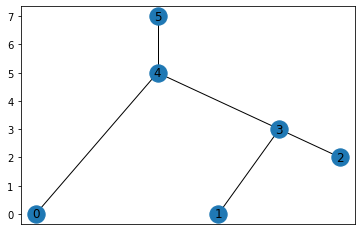

In [4]:
draw_merge_tree(T1,height1,axes = True)

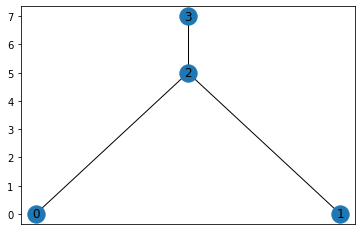

In [5]:
draw_merge_tree(T2,height2,axes = True)

### Estimating Merge Tree Interleaving Distance

One can define a metric on the space of merge trees called *interleaving distance* which is inspired by bottleneck distance between persistence diagrams (see *Interleaving distance between merge trees* by Morozov et al., 2013 or Section 4.3 of [1]). Interleaving distance is not tractable to compute exactly, but we introduce a method to estimate it by using Gromov-Wasserstein distance from optimal transport theory (see Section 6.5 of [1]). 

To improve the accuracty, the user can subdivide the merge trees by specifying a mesh. Generally, a smaller mesh yields a more accurate distance, but a finer mesh incurs a higher computational cost. 

In [6]:
mesh = 1
T1_sub, height1_sub, T2_sub, height2_sub, res = subdivide_and_compute_distance(T1,height1,T2,height2,mesh) 
# Returns subdivided merge trees plus a dictionary with several results

print('Interleaving Distance:',res['dist'])

AttributeError: 'Graph' object has no attribute 'tree'

The distance computation returns several outputs, which can be used to visualize the way that the distance computation works.

The 'coupling' key in the dictionary `res` returns a probabilistic matching between the nodes of the subdivided trees.

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(res['coupling'])
plt.colorbar()
plt.show()

The distance computation proceeds by estimating an 'optimal labeling' of the merge trees from the coupling. The 'labeling' approach to merge tree interleaving was introduced in Gasparovic et al., *Intrinsic interleaving distance for merge trees*, 2019. The figure below shows the optimal labeling.

Nodes with the same label across the two merge trees should be thought of as 'structurally matched'.

In [7]:
labels1New = res['label1']
labels2New = res['label2']

draw_labeled_merge_tree(T1_sub,height1_sub,labels1New)
plt.show()
draw_labeled_merge_tree(T2_sub,height2_sub,labels2New)
plt.show()

NameError: name 'res' is not defined

### Creating a Merge Tree from Data

Generally, we would be generating merge trees from a dataset. Let's start with a toy dataset consisting of a point cloud in 2D. We'll write some functions to generate random point clouds with topological structure.

In [8]:
def noisy_circle(n_samples, noise_level, center_x, center_y ,radius):

    t = np.linspace(0,2*np.pi,n_samples)
    x = center_x + radius*np.cos(t)
    y = center_y + radius*np.sin(t)
    noise = np.random.rand(n_samples,2)
    data = np.array([x,y]).T + noise_level*radius*noise

    return data

def noisy_disk(n_samples,noise_level,center_x,center_y,radius):

    t = np.linspace(0,2*np.pi,n_samples)
    r = radius*np.random.rand(n_samples)
    x = center_x + np.multiply(r,np.cos(t))
    y = center_y + np.multiply(r,np.sin(t))
    noise = np.random.rand(n_samples,2)
    data = np.array([x,y]).T + noise_level*radius*noise

    return data

def one_disk_two_circles(radii, separation, n_samples_per_shape = 50, noise_level = 0.5, centersy = None):
    
    """
    This example produces one disk and two circles or radii r1,r2,r3. The circles are clustered together and 
    the disk is separated in the x-direction by `separation`
    In: triple of radii = [r1,r2,r3], separation distance
    """
    
    data = np.zeros([n_samples_per_shape*3,2])
    
    shapes = ['disk','circle','circle']
    r1 = radii[0]
    r2 = radii[1]
    r3 = radii[2]
    centersx = [0,r1+separation+r2,r1+separation+2*r2+r3]
    
    if centersy is None:
        centersy = [0,0,0]
    
    num_shapes = len(shapes)
    
    for j in range(num_shapes):
        if shapes[j] == 'disk':
            shape = noisy_disk(n_samples_per_shape,noise_level,centersx[j],centersy[j],radii[j])
        elif shapes[j] == 'circle':
            shape = noisy_circle(n_samples_per_shape, noise_level,centersx[j],centersy[j],radii[j])
        data[j*n_samples_per_shape:(j+1)*n_samples_per_shape,:] = shape
        
    return data

def three_circles(radii, separation1, separation2, n_samples_per_shape = 50, noise_level = 0.5, centersy = None):
    
    
    data = np.zeros([n_samples_per_shape*3,2])
    
    shapes = ['circle','circle','circle']
    r1 = radii[0]
    r2 = radii[1]
    r3 = radii[2]
    centersx = [0,r1+separation1+r2,r1+separation1+r2]
    
    if centersy is None:
        centersy = [0,0,r2+separation2+r3]
    
    num_shapes = len(shapes)
    
    for j in range(num_shapes):
        if shapes[j] == 'disk':
            shape = noisy_disk(n_samples_per_shape,noise_level,centersx[j],centersy[j],radii[j])
        elif shapes[j] == 'circle':
            shape = noisy_circle(n_samples_per_shape, noise_level,centersx[j],centersy[j],radii[j])
        data[j*n_samples_per_shape:(j+1)*n_samples_per_shape,:] = shape
        
    return data

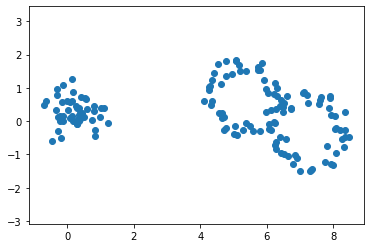

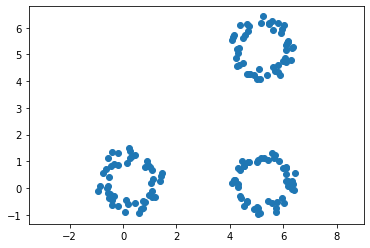

In [9]:
data1 = one_disk_two_circles([1,1,1],3,centersy = [0,0.5,-0.5])

plt.scatter(data1[:,0],data1[:,1])
plt.axis('equal')
plt.show()

data2 = three_circles([1,1,1],3,3)

plt.scatter(data2[:,0],data2[:,1])
plt.axis('equal')
plt.show()

Now we create a merge tree by tracking merging of connected components in the Vietoris-Rips complexes as the parameter increases. The result is also known as a **single linkage hierarchical clustering dendrogram**. This can be computed using standard packages. We use the `linkage` function from `scipy` to get the dendrogram structure. It can be visualized with the `dendrogram` function.

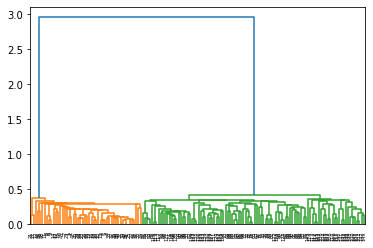

In [10]:
L = linkage(data1)
dendrogram(L)
plt.show()

We convert the linkage into our merge tree data structure using our `linkage_to_merge_tree` function.

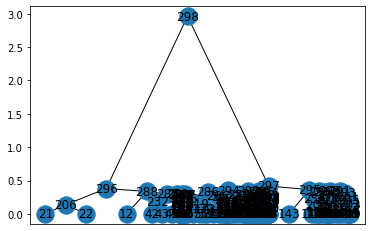

In [11]:
T1, height1 = linkage_to_merge_tree(L,data1)
draw_merge_tree(T1,height1,axes = True)

The merge tree for the second dataset is shown below.

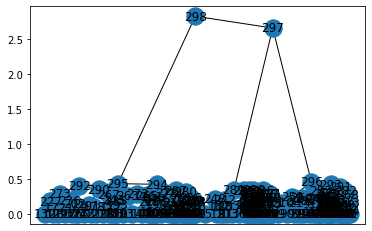

In [12]:
L = linkage(data2)
T2, height2 = linkage_to_merge_tree(L,data2)
draw_merge_tree(T2,height2,axes = True)

### Simplifying Merge Trees

The merge trees shown above are quite complicated. We can get simplified versions by slicing at a given height and merging all nodes below the threshold height to a single node at height zero (more generally, at the lowest leaf height below the threshold point in each branch). This is akin to throwing away bars in a barcode with sufficiently low persistence. The resulting visualizations are much easier to parse and the simplification improves computation time for computing interleaving distance.

The code below performes this simplification at a user-defined threshold height.

In [13]:
threshold = 0.4

T_thresh1, height_thresh1 = simplify_merge_tree_with_threshold(T1,height1,threshold)
draw_merge_tree(T_thresh1,height_thresh1,axes = True)

NameError: name 'simplify_merge_tree_with_threshold' is not defined

In [ ]:
T_thresh2, height_thresh2 = simplify_merge_tree_with_threshold(T2,height2,threshold)
draw_merge_tree(T_thresh2,height_thresh2,axes = True)

### Simple Distance Comparison

Let's check that our estimation of merge tree interleaving distance is able to distinguish between the classes that we've defined above.

**Known Issue:** The current implementation of interleaving distance is not optimized, so it runs slowly and is somewhat sensitive to parameters. The code will be updated soon with an improved version!

In [ ]:
# Create dataset of 2 samples for each of the two classes
print('Creating Data...')
point_clouds = [one_disk_two_circles([1,1,1],3,centersy = [0,0.5,-0.5]),
               one_disk_two_circles([1,1,1.1],3,centersy = [0,0.5,-0.5]),
                three_circles([1,1,1],3,3),
                three_circles([1,1,1.1],3,3)]

Ts = []
heights = []
threshold = 1

for point_cloud in point_clouds:
    L = linkage(point_cloud)
    T, height = linkage_to_merge_tree(L,point_cloud)
    T_thresh, height_thresh = simplify_merge_tree_with_threshold(T,height,threshold)
    Ts.append(T_thresh)
    heights.append(height_thresh)
    
# Compute a 4x4 pairwise distance matrix

print('Computing Pairwise Distances...')
distMat = np.zeros([4,4])

mesh = 0.2

for i in range(4):
    print('row=',i)
    Ti = Ts[i]
    heighti = heights[i]
    for j in range(i+1,4):
        Tj = Ts[j]
        heightj = heights[j]
        _, _, _, _, res = subdivide_and_compute_distance(Ti,heighti,Tj,heightj,mesh)
        distMat[i,j] = res['dist']
        
distMat += distMat.T

plt.imshow(distMat)
plt.title('Distance Matrix',fontsize = 16)
plt.show()

Apparently the merge tree interleaving distance estimation is able to distinguish these simple classes.

## Decorated Merge Trees (DMTs)

Decorated Merge Trees fuse persistent connectivity data (the merge tree) with higher dimensional persistent homological data (barcodes).

### Creating DMTs from Data

The code below creates a DMT from the first dataset created above. Specifically, it creates a *Barcode Decorated Merge Tree* from Section 3.3 of [1]. This attaches a barcode to each leaf of the merge tree.

In this example, we are attaching a degree-1 persistent homology barcode to each leaf of the merge tree. The persistent homology computation is handled by `ripser`.

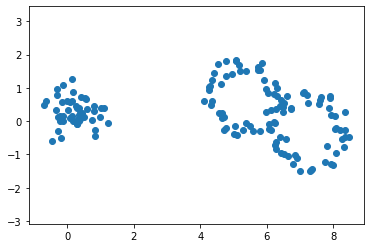

In [14]:
plt.scatter(data1[:,0],data1[:,1])
plt.axis('equal')
plt.show()

In [15]:
L = linkage(data1)
T1, height1 = linkage_to_merge_tree(L,data1)
dgms = ripser(data1)['dgms']
dgm1 = dgms[1]
leaf_barcode1 = decorate_merge_tree(T1, height1, data1, dgm1)

The leaf barcode is a dictionary. Keys are node IDs and values are barcodes.

In [16]:
leaf_barcode1[0]

[[0, 0],
 [0, 0],
 [0, 0],
 [0.3912215232849121, 0.44999298453330994],
 [0, 0],
 [0, 0],
 [0.34423530101776123, 0.4805377125740051],
 [0, 0],
 [0, 0],
 [0.300556480884552, 0.3426300585269928],
 [0.2770557105541229, 0.3434337079524994],
 [0, 0],
 [0, 0],
 [0, 0],
 [0.2566206423788762, 0.26942178606987],
 [0, 0],
 [0, 0]]

### Simplifying DMTs

When we simplify a merge tree, as describe above, we can also simplify the leaf decorations. The leaves in the simplified merge tree keep their associated barcode computed above.

In [17]:
threshold = 0.5
T_thresh, height_thresh, leaf_barcode_thresh = simplify_decorated_merge_tree(T1,height1,leaf_barcode1,threshold)

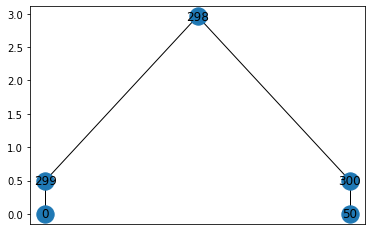

In [18]:
draw_merge_tree(T_thresh,height_thresh,axes = True)

In [21]:
leaf_barcode_thresh

{50: [[0.44491246342658997, 1.469643235206604],
  [0.42110273241996765, 1.5566754341125488],
  [0.32229629158973694, 0.4309801161289215],
  [0.29368844628334045, 0.3483414351940155],
  [0.255251542575336, 0.2576756477355957],
  [0.255251542575336, 0.27104100584983826]],
 0: [[0.4537736177444458, 0.46795278787612915],
  [0.3753744661808014, 0.4673810303211212],
  [0.320809543132782, 0.41981229186058044],
  [0.2764245867729187, 0.2949334681034088],
  [0.2732955813407898, 0.3355943560600281],
  [0.2731650471687317, 0.358557790517807],
  [0.24885049984262061, 0.26115307211875916],
  [0.24874876362133164, 0.2682587206363678]]}

The two apparent loops in the dataset should be represented by two long bars attached to a leaf (or to several leaves which merge at a relatively low height). This corresponds to the two loops lying in a single connected component.

### Visualizing DMTs

We can visualize our DMT by enriching the merge tree with overlaid barcodes. This corresponds to the 'lift decoration' process described in Section 5.4 of [1]. 

To get a nice looking picture, we only include bars whose persistence is larger than a given threshold. Now there are two parameters involved in visualizing a DMT: the height at which to truncate the tree and the persistence of bars that we want to display overlaid on the tree.

We can predetermine a good threshold for persistence of bars by visualizing the persistence diagram. We use the `persim` package and plot in 'lifetime' mode, so that the persistence of a bar is more apparent.

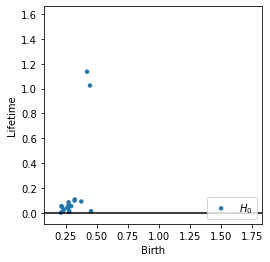

In [22]:
persim.plot_diagrams(dgm1,lifetime = True)

The DMT visualization function has various outputs which can be used to draw a more customized DMT. This can be supressed by setting the option `return_data = False`.

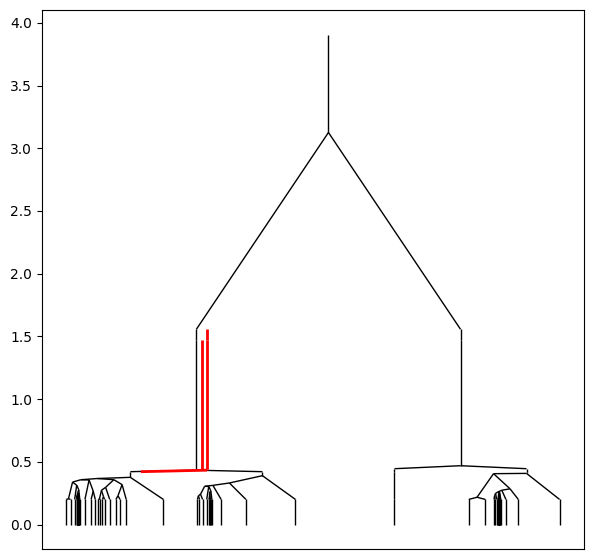

In [23]:
tree_thresh = 0.2
barcode_thresh = 0.4

T_DMT, pos_DMT, edges, colors, weights = visualize_DMT_pointcloud(T1,height1,dgm1,data1,tree_thresh,barcode_thresh)

Observe that the DMT simultaneously illustrates the connected component and loops structure of the dataset, together with how these structures interact!

Here is a code block to draw a DMT for the second dataset defined above.

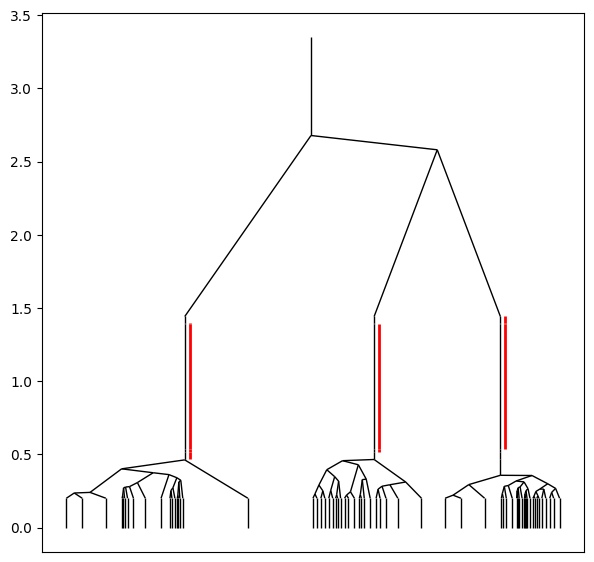

In [24]:
L = linkage(data2)
T2, height2 = linkage_to_merge_tree(L,data2)
dgms = ripser(data2)['dgms']
dgm2 = dgms[1]
leaf_barcode2 = decorate_merge_tree(T2, height2, data2, dgm2)

tree_thresh = 0.2
barcode_thresh = 0.4

visualize_DMT_pointcloud(T2,height2,dgm2,data2,tree_thresh,barcode_thresh, return_data = False)

### Comparing DMTs

Decorated merge trees can be compared using the decorated bottleneck distance defined in Section 4.5 of [1]. We can estimate this distance using a variant of Gromov-Wasserstein distance called [Fused Gromov-Wasserstein Distance](https://arxiv.org/abs/1811.02834). This involves another parameter $\alpha$, which balances the weight of degree-0 vs. higher degree homology when finding a merge tree interleaving. 

Details and more examples will be provided in a followup notebook. The basic syntax for computing the distance is shown below. It is computationally beneficial to simplify the merge tree (as above) before computing the distance. As is the case for merge tree interleaving, this distance computation is **not yet optimized**---faster versions of this algorithm will be included in future updates to the code base.

In [25]:
threshold = 0.5
mesh = 0.2
alpha = 0.5

T_thresh1, height_thresh1, leaf_barcode_thresh1 = simplify_decorated_merge_tree(T1,height1,leaf_barcode1,threshold)
T_thresh2, height_thresh2, leaf_barcode_thresh2 = simplify_decorated_merge_tree(T2,height2,leaf_barcode2,threshold)

_, _, _, _, _, dist = fusedGW_subdivide_and_compute_decorated_distance(T_thresh1,height_thresh1,leaf_barcode_thresh1,
                                                                        T_thresh2,height_thresh2,leaf_barcode_thresh2,
                                                                        mesh, alpha = alpha)

print('Decorated Bottlneck Distance:',dist)

Decorated Bottlneck Distance: 2.0529146429808875
